In [5]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner

import jax
import jax.numpy as jnp
import numpyro

from flowjax.distributions import Normal
from flowjax.flows import BlockNeuralAutoregressiveFlow
from flowjax.train import fit_to_data

In [13]:
np.random.seed(0)
key = jax.random.PRNGKey(0)

In [10]:
n = 10_000
x = np.random.normal(loc=2, scale=0.5, size=n)
y = np.random.normal(loc=-2, scale=2, size=n)
z = np.transpose([x, y])
dim = z.shape[1]

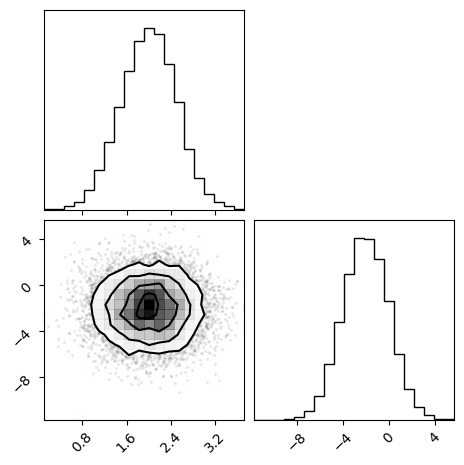

In [11]:
corner(z);

In [34]:
base = Normal(jnp.zeros(dim), jnp.ones(dim))

key, key_ = jax.random.split(key)
flow = BlockNeuralAutoregressiveFlow(
    key_,
    base,
    cond_dim=None,
    nn_depth=1,
    nn_block_dim=5,
    flow_layers=1,
    invert=True,
    )

In [36]:
potential_fn = lambda x: -flow.log_prob(x).squeeze()
nuts = numpyro.infer.NUTS(potential_fn=potential_fn)
mcmc = numpyro.infer.MCMC(
    sampler=nuts,
    num_warmup=1_000,
    num_samples=1_000,
    progress_bar=True,
    jit_model_args=True,
    )

key, key_ = jax.random.split(key)
mcmc.run(key_, init_params=jnp.zeros(dim))
mcmc.print_summary()

pred = mcmc.get_samples()

sample: 100%|████████| 2000/2000 [00:08<00:00, 225.65it/s, 7 steps of size 1.44e-02. acc. prob=0.90]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]    -12.65     60.69     -1.35   -164.27     12.23     91.52      1.02
Param:0[1]     17.83     48.77      1.96    -13.29    114.45     30.38      1.04

Number of divergences: 0


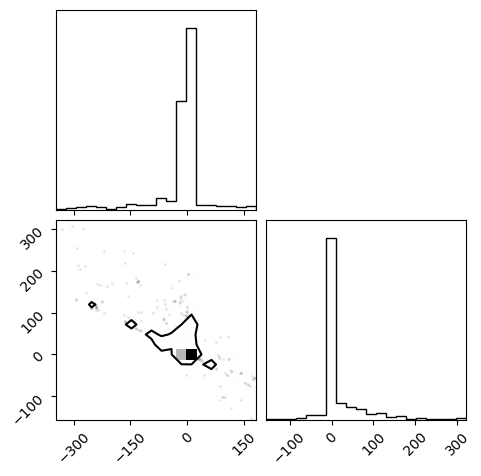

In [37]:
corner(np.array(pred));

In [38]:
key, key_ = jax.random.split(key)
flow, losses = fit_to_data(
    key=key_,
    dist=flow,
    x=z,
    loss_fn=None,
    max_epochs=100,
    max_patience=10,
    batch_size=100,
    val_prop=0.1,
    learning_rate=1e-2,
    optimizer=None,
    # filter_spec: Callable | PyTree = eqx.is_inexact_array,
    show_progress=True,
    )

 39%|██▋    | 39/100 [00:23<00:36,  1.65it/s, train=2.8371494, val=2.8715916 (Max patience reached)]


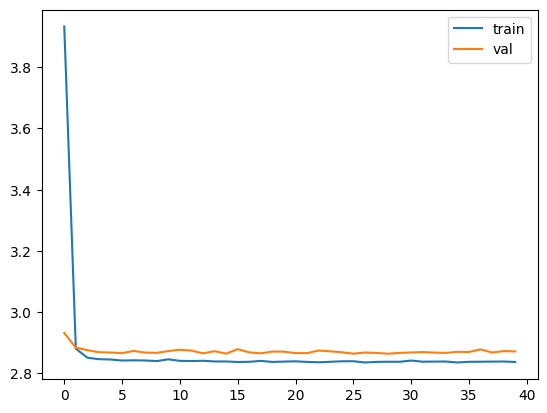

In [39]:
for label, loss in losses.items():
    plt.plot(loss, label=label)
plt.legend();

In [43]:
potential_fn = lambda x: -flow.log_prob(x).squeeze()
nuts = numpyro.infer.NUTS(potential_fn=potential_fn)
mcmc = numpyro.infer.MCMC(
    sampler=nuts,
    num_warmup=1_000,
    num_samples=10_000,
    progress_bar=True,
    jit_model_args=True,
    )

key, key_ = jax.random.split(key)
mcmc.run(key_, init_params=jnp.zeros(dim))
mcmc.print_summary()

pred = np.array(mcmc.get_samples())

sample: 100%|██████| 11000/11000 [00:12<00:00, 899.58it/s, 3 steps of size 9.60e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]      2.00      0.51      2.00      1.23      2.90   8955.79      1.00
Param:0[1]     -2.05      1.98     -2.09     -5.30      1.15   8740.24      1.00

Number of divergences: 0


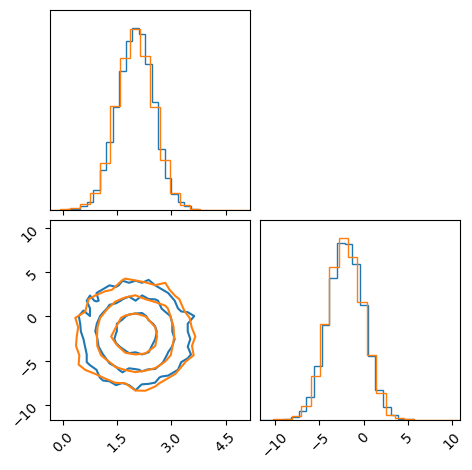

In [44]:
fig = corner(
    z, plot_datapoints=False, plot_density=False,
    levels=[0.5, 0.9, 0.99],
    hist_kwargs={'density': True, 'color': plt.get_cmap('tab10')(0)},
    contour_kwargs={'colors': [plt.get_cmap('tab10')(0)]},
    )

corner(
    pred, fig=fig, plot_datapoints=False, plot_density=False,
    levels=[0.5, 0.9, 0.99],
    hist_kwargs={'density': True, 'color': plt.get_cmap('tab10')(1)},
    contour_kwargs={'colors': [plt.get_cmap('tab10')(1)]},
    );